<a href="https://www.kaggle.com/code/crisbebop/random-forest-0-98460?scriptVersionId=194194718" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Mushrooms Binary Classification / Random Forest
In this notebook:  

* Using extra dataset
* Retaining all columns and encoding NaN values as a distinct category (for categorical features)
* Use a utility script to encoding by frequency, [here the script](https://www.kaggle.com/code/crisbebop/frequency-encoder-py)
* Imputing missing values (numerical features) using KNN
* Performing 5-fold cross-validation
* Saving OOB (Out-Of-Bag) predictions  

## Previous results OOB

|Criterion | Estimators| Preprocess | OOB MCC|Cross-val Time spent (min)|
-----------|-----------|------------|--------|----------------|
| Gini | 100 | extra_data+Clean_noise+FE+KNN_imp+Robust|0.98449 |
| Gini | 300 | " | 0.98454 | |
| Gini | 500 | "  | 0.98455 |174.82|
| Entropy| 100 | " | 0.98448 | |
| Entropy| 300 | " |  0.98454| |
| Entropy | 500 |  " | 0.98457| 162.35 |
| Entropy | 500 | extra_data+FE+KNN_imp+Robust | 0.98460 | 141.77 |



# Loads and imports

In [1]:
# Imports and settings
import pandas as pd
import numpy as np
from time import time
from datetime import datetime
import math

# settings
import warnings
warnings.filterwarnings('ignore')
random_state = 2024
np.seed = random_state
import gc

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid') # Theme for plots as Dark
sns.set_palette('pastel')

#Metrics and val
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.model_selection import train_test_split, KFold

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

# Preprocess
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler

# Import the utiliy script
import sys
sys.path.append('/kaggle/input/frequency-encoder')
from frequency_encoder_py import FrequencyEncoder

In [2]:
# Load data
train_competition = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col='id')
train_original    = pd.read_csv("/kaggle/input/secondary-mushroom-dataset-data-set/MushroomDataset/secondary_data.csv", sep=";")
train_data = pd.concat([train_competition, train_original], ignore_index=True)
test_data = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col='id')
ids = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')['id'].astype(np.int32)
print('data loaded!')

data loaded!


# First look

In [3]:
display(print(f'Shape of train dataset: {train_data.shape}'), print(f'Shape of test dataset: {test_data.shape}'), print(f'Duplicated rows: {train_data.duplicated().sum()}\n'),train_data.describe().T, train_data.sample(3), train_data.info())

Shape of train dataset: (3178014, 21)
Shape of test dataset: (2077964, 20)
Duplicated rows: 146

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178014 entries, 0 to 3178013
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season         

None

None

None

,count,mean,std,min,25%,50%,75%,max
cap-diameter,3178010.0,6.317996,4.670698,0.03,3.32,5.75,8.24,80.67
stem-height,3178014.0,6.352815,2.714383,0.00,4.67,5.88,7.41,88.72
stem-width,3178014.0,11.172917,8.138274,0.00,4.97,9.66,15.65,103.91


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
2518480,e,5.21,s,w,y,f,f,f,f,2.57,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
1063666,e,15.53,x,e,n,f,d,c,w,10.20,...,s,NaN,w,NaN,NaN,f,f,NaN,g,a
1999160,e,7.88,x,s,w,f,s,c,w,6.52,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,s


None

In [4]:
#Drop duplicates
train_data.drop_duplicates(inplace=True)

In [5]:
train_data['class'] = train_data['class'].map({'p': 1, 'e': 0})

In [6]:
# Features types
cat_features = train_data.select_dtypes(include='object').columns
num_features = train_data.select_dtypes(include=['int64', 'float64']).columns

In [7]:
def plot_histograms(df, variable_list):
    num_vars = len(variable_list)
    num_cols = 3
    num_rows = math.ceil(num_vars / num_cols)

    plt.figure(figsize=(num_cols * 4, num_rows * 3))
    for i, column in enumerate(variable_list, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.histplot(df[column], bins=20, kde=False, color='skyblue')
        plt.title(f'Histogram of {column}')
        if df[column].nunique() < 20:
            plt.xlabel(column)
            plt.xticks(rotation=45)
        else:
            plt.xticks([])  # No labels for axis x
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

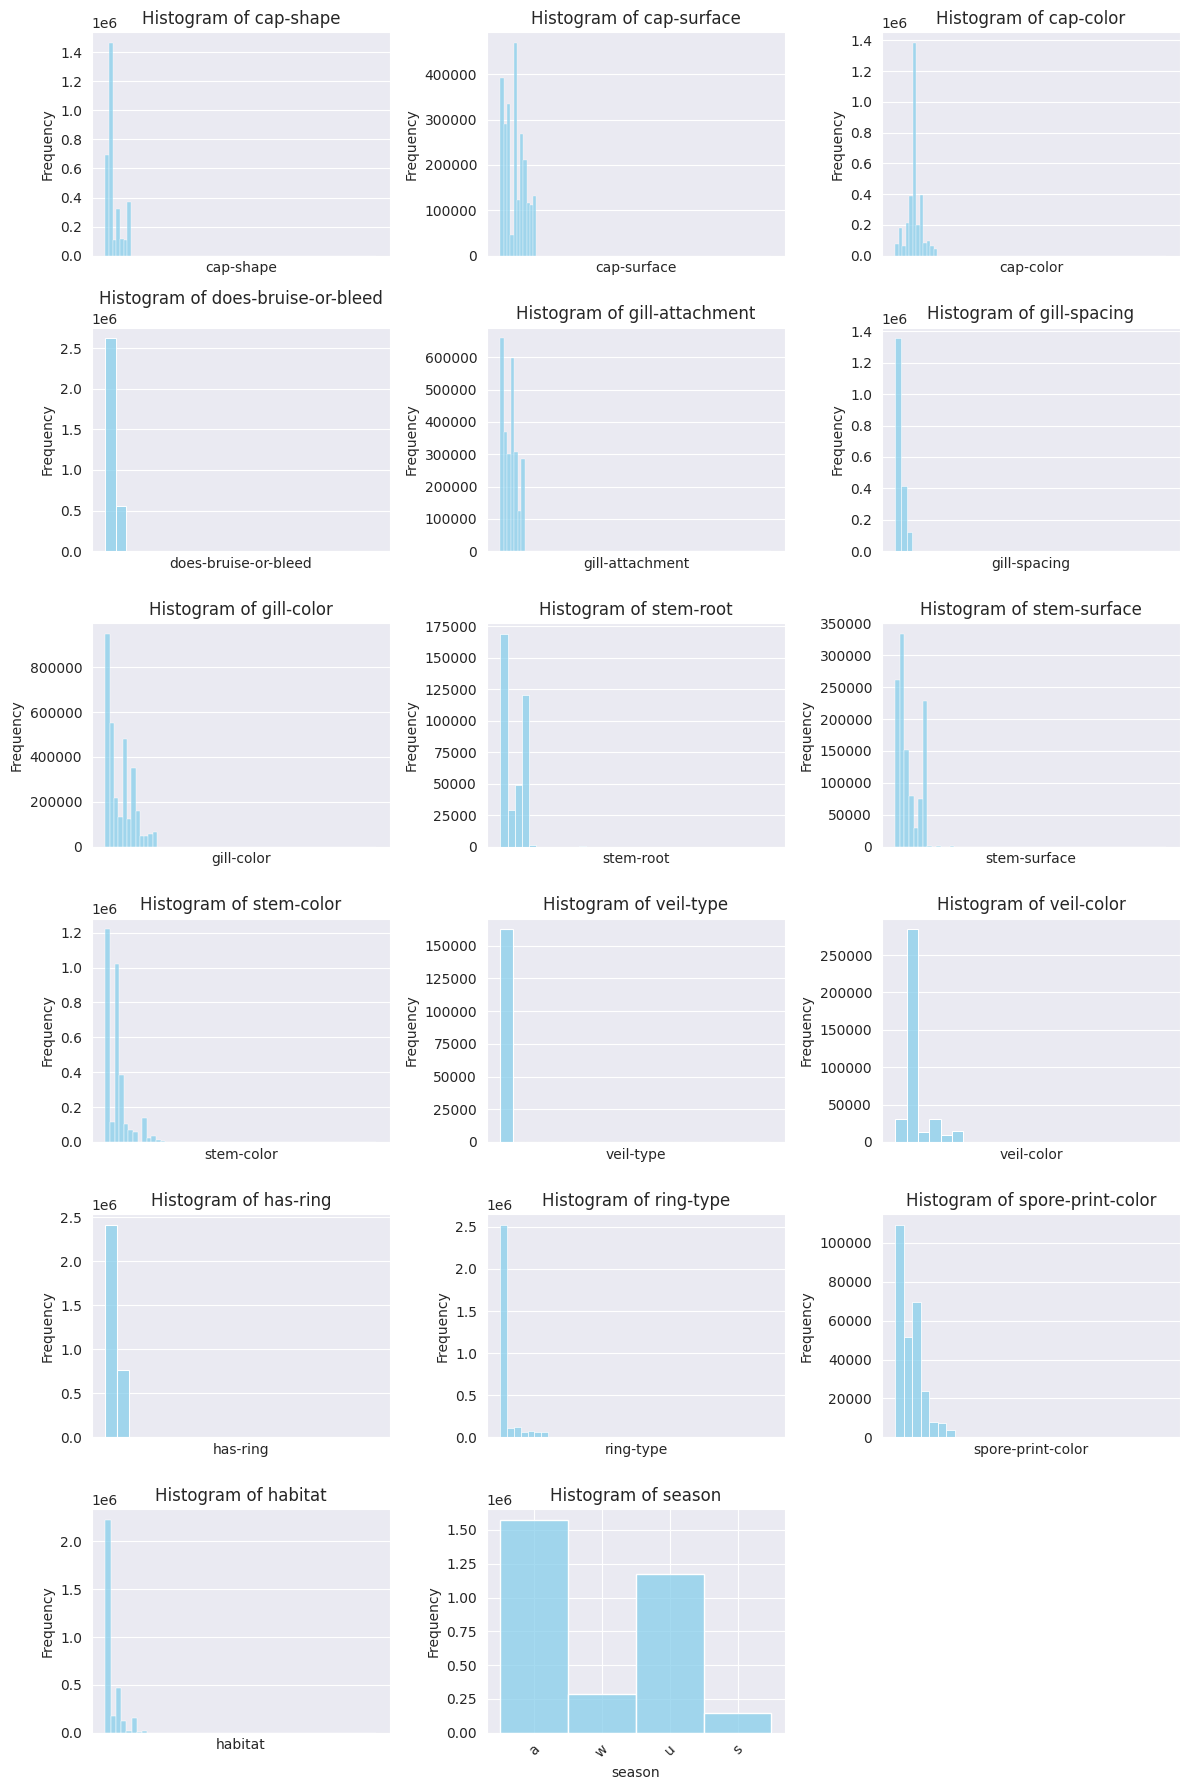

In [8]:
plot_histograms(train_data, cat_features)

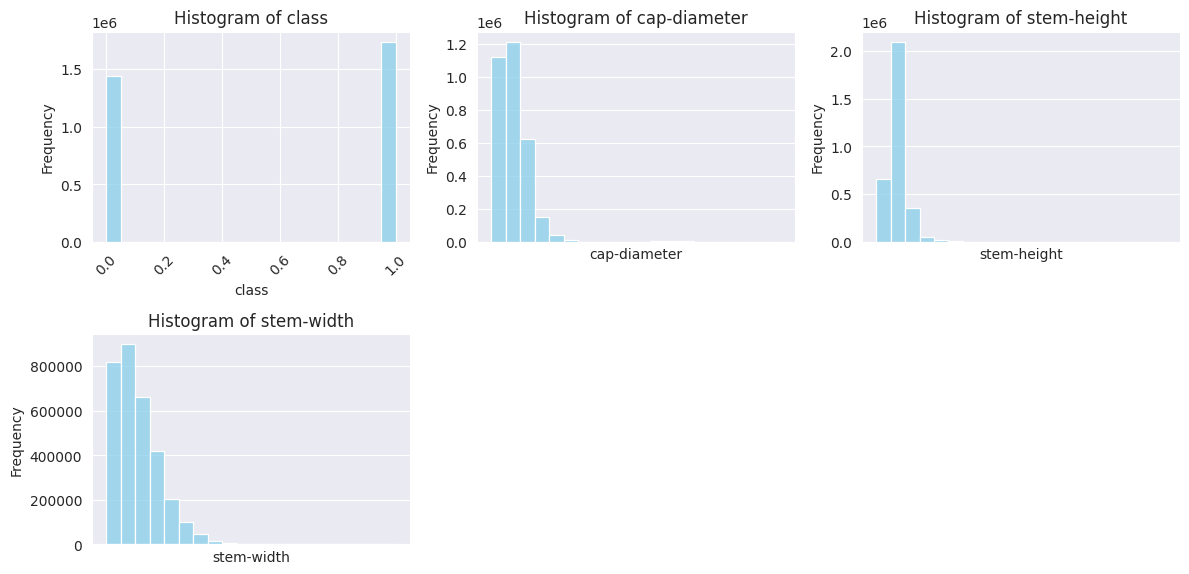

In [9]:
plot_histograms(train_data, num_features)

There are a lot of classes in the categorical features and a huge amount of missing values...

In [10]:
train_data.nunique().to_frame('Nunique_values')

,Nunique_values
class,2
cap-diameter,3914
cap-shape,74
cap-surface,83
cap-color,78
does-bruise-or-bleed,26
gill-attachment,78
gill-spacing,48
gill-color,63
stem-height,2758


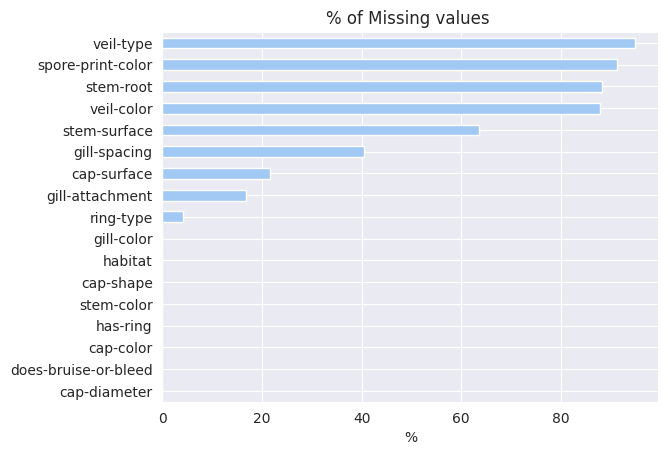

In [11]:
# % of Missing Values
missing = train_data.isnull().sum()
missing = missing[missing > 0]
missing_percentage = (missing / len(train_data)) * 100

# Sort
missing_percentage.sort_values(inplace=True)

# Plot
missing_percentage.plot.barh()
plt.xlabel('%')
plt.title('% of Missing values ')
plt.show()

# Encoding and preprocessing

In [12]:
y = train_data['class']
X = train_data.drop('class', axis=1)

In [13]:
# Encoding by frequency

encoder = FrequencyEncoder()
encoder.fit(X[cat_features])
X[cat_features] = encoder.transform(X[cat_features])
test_data[cat_features] = encoder.transform(test_data[cat_features])
print('Frequency encoding done!')

Frequency encoding done!


In [14]:
# Resume of Nan values
print(X.isna().sum().to_frame('Nan'))
print(test_data.isna().sum().to_frame('Nan'))

                      Nan
cap-diameter            4
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
veil-type               0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
                      Nan
cap-diameter            7
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             1
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
veil-type               0
veil-color              0
has-ring                0
ring-type   

In [15]:
# KNN Imputer

X_nan_col = X.columns[X.isna().any()].tolist()
test_nan_col = test_data.columns[test_data.isna().any()].tolist()

columns_with_nan = list(set(X_nan_col) | set(test_nan_col))

# Create and apply imputer
knn_imputer = KNNImputer(n_neighbors=5)

X[columns_with_nan] = knn_imputer.fit_transform(X[columns_with_nan])
test_data[columns_with_nan] = knn_imputer.transform(test_data[columns_with_nan])

In [16]:
X[cat_features].nunique().to_frame('nunique_counts')

,nunique_counts
cap-shape,24
cap-surface,28
cap-color,26
does-bruise-or-bleed,12
gill-attachment,24
gill-spacing,14
gill-color,28
stem-root,19
stem-surface,25
stem-color,27


In [17]:
# RobustScaler
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns= X.columns)
test_data = pd.DataFrame(scaler.transform(test_data), columns = X.columns)

# Random Forest Classifier

In [18]:
# Rf
rf = RandomForestClassifier(
    n_estimators = 500,
    criterion= 'entropy',
    n_jobs= -1,
    random_state=random_state
)

# Cross-Val

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

In [20]:
def cross_val(X, y, kf, test):

    start= time()

    folds = kf # definir antes
    test_preds = np.zeros(len(test))
    oof_preds = np.zeros(len(y))
    y_vals = np.zeros(len(y))
    scores=[]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
        X_train_, y_train_ = X.iloc[train_idx], y.iloc[train_idx]
        X_val_, y_val_ = X.iloc[valid_idx], y.iloc[valid_idx]

        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f'Fitting Fold {n_fold + 1} started at {current_time}')

        model = clone(rf)
    
        model.fit(X_train_,y_train_, 
                 )
            
        y_pred_val = model.predict_proba(X_val_)[:,1]
        oof_preds[valid_idx] = y_pred_val
        y_vals[valid_idx] = y_val_
        score = matthews_corrcoef(y_val_, y_pred_val > 0.5)

        scores.append(score)  
        test_preds += model.predict_proba(test)[:,1]/ folds.get_n_splits()

        print(f'\nFold {n_fold + 1} MCC score : {score:.5f}')
        print('-' * 100)
        
        del X_train_, y_train_, X_val_, y_val_, model
        gc.collect()

    # Salida de resultados    
    print(f'train MCC scores: {scores}')
    print(f'Mean MCC score +/- std. dev.: '
        f'{np.array(scores).mean():.5f} +/- {np.array(scores).std():.3f}')
    print(f'\nTime spent[s]: {(time()-start)/60:.2f} minutes')

    return oof_preds, y_vals, test_preds

In [21]:
train_preds, y_vals, test_preds = cross_val(X, y, kf, test_data)

Fitting Fold 1 started at 2024-08-26 21:07:04

Fold 1 MCC score : 0.98465
----------------------------------------------------------------------------------------------------
Fitting Fold 2 started at 2024-08-26 21:37:15

Fold 2 MCC score : 0.98465
----------------------------------------------------------------------------------------------------
Fitting Fold 3 started at 2024-08-26 22:07:35

Fold 3 MCC score : 0.98471
----------------------------------------------------------------------------------------------------
Fitting Fold 4 started at 2024-08-26 22:37:43

Fold 4 MCC score : 0.98422
----------------------------------------------------------------------------------------------------
Fitting Fold 5 started at 2024-08-26 23:08:29

Fold 5 MCC score : 0.98477
----------------------------------------------------------------------------------------------------
train MCC scores: [0.9846469178139814, 0.9846502160713126, 0.9847148234754804, 0.9842242893976719, 0.9847652507622131]
Mean M

In [22]:
print(f' OOB MCC: {matthews_corrcoef(y_vals,train_preds>0.5):.5f}')

 OOB MCC: 0.98460


In [23]:
# Save oob probs & test_preds prob
oob_prob = pd.DataFrame(train_preds, columns = ['oob_prob_rf'])
oob_prob.to_csv('oob_prob_rf.csv')

test_prob = pd.DataFrame(test_preds, columns = ['test_prob_rf'])
test_prob.to_csv('test_prob_rf.csv')

# Predictions and submission

In [24]:
binary_predictions = (test_preds > 0.5).astype(int)

predictions = pd.DataFrame(binary_predictions, columns=['class'])
predictions['class'] = predictions['class'].map({1: 'p', 0: 'e'})
predictions.head()

,class
0,e
1,p
2,p
3,p
4,e


In [25]:
submission = pd.DataFrame()
submission["id"] = ids
submission["class"] = predictions
submission.to_csv("submission.csv",header=True, index=False)
submission.head()

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
